In [43]:
from UTILITY_quickstart import *

In [44]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch_baseline.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_twoIslandStudy.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline2.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline2.1.yml")

#importedDefaultSettings = importedDefaultSettings | {"inputBeamFilePathSuffix" : '/beams/2024-10-14_Impact_TwoBunch/2024-10-14_twoBunch.h5'}
#importedDefaultSettings = importedDefaultSettings | {"inputBeamFilePathSuffix" : '/beams/2025-05-14_twobunch_unoptimized_shorterSpacing/2025-05-14_twobunch_unoptimized_shorterSpacing.h5', "L2PhaseSet" : -38, "L1PhaseSet" : -17}

#importedDefaultSettings = loadConfig("setLattice_configs/2025-06-17_twoBunch_forMuons_6GeV.yml")

In [45]:
csrTF = True
evalElement = "PENT"
#evalElement = "BEGPDC"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)


#tao.cmd("set ele * space_charge_method = slice")
#tao.cmd("set ele * space_charge_method = fft_3d")


setLattice(tao, **importedDefaultSettings)


#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-S2E
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using /Users/nmajik/Documents/SLAC/FACET2-S2E/setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_8215826581029359321.h5, and reinit to tao
Loaded /tmp/beams/activeBeamFile_8215826581029359321.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [46]:
trackBeam(tao, 
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_8215826581029359321.h5
Set track_start = L0AFEND, track_end = end
Set track_end = MFFF
Tracking!
Beam centered at MFFF written to /tmp/beams/patchBeamFile_8215826581029359321.h5
Loaded /tmp/beams/patchBeamFile_8215826581029359321.h5
Set track_start = MFFF, track_end = end
Tracking!
trackBeam() exiting


In [47]:
print( np.median( (getBeamAtElement(tao, "BEGBC14_1")).energy ) * 1e-6 )
print( np.median( (getBeamAtElement(tao, "BEGBC20")).energy ) * 1e-6 )

4500.357008685442
9999.94424286846


In [5]:
P = getBeamAtElement(tao, evalElement)


if bunchCount == 1:
    PDrive = P.copy()
elif bunchCount == 2:
    PDrive, PWitness = getDriverAndWitness(P)


savedData = getBeamSpecs(P, targetTwiss = evalElement)

savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [6]:
(getBeamAtElement(tao, "PENT")).write("beams/optimizerRunningBestBeam_PENT.h5")
savedData

{'PDrive_median_x': np.float64(-2.47523735187547e-05),
 'PDrive_median_y': np.float64(1.3708059112900224e-06),
 'PDrive_median_xp': np.float64(0.0003295322907554514),
 'PDrive_median_yp': np.float64(2.4835231453041983e-05),
 'PDrive_median_energy': np.float64(9940955744.776834),
 'PDrive_sigmaSI90_x': np.float64(6.102402666977675e-05),
 'PDrive_sigmaSI90_y': np.float64(1.0865084010716337e-05),
 'PDrive_sigmaSI90_z': np.float64(6.103102142643011e-05),
 'PDrive_sigmaSI90_xp': np.float64(0.0001943174210064501),
 'PDrive_sigmaSI90_yp': np.float64(3.497838567863432e-05),
 'PDrive_sigmaSI90_energy': np.float64(88748246.82985756),
 'PDrive_emitSI90_x': np.float64(5.3111783086170446e-05),
 'PDrive_emitSI90_y': np.float64(6.943187448451998e-06),
 'PDrive_norm_emit_x': np.float64(2.7388742414611083e-05),
 'PDrive_norm_emit_y': np.float64(2.9741451533644125e-06),
 'PDrive_charge_nC': np.float64(1.5996800000000009),
 'PDrive_BMAG_x': np.float64(2.6961634355317274),
 'PDrive_BMAG_y': np.float64(1.3

In [7]:
if bunchCount == 2:
    print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")
    
    print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
    print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
if bunchCount == 2:
    print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_z"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
if bunchCount == 2: 
    print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g} × {1e6 * PDrive["sigma_y"] :.3g} × {1e6 * PDrive["sigma_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g} × {1e6 * PWitness["sigma_y"] :.3g} × {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - implied by 90% charge
Driver emittance: 	53.1 × 6.94 um-rad
Driver sigma_x,y,z: 	61 × 10.9 × 61 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	85.5 × 8.79 um-rad
Driver sigma_x,y,z: 	67.6 × 12.3 × 67.5 um


Drive:


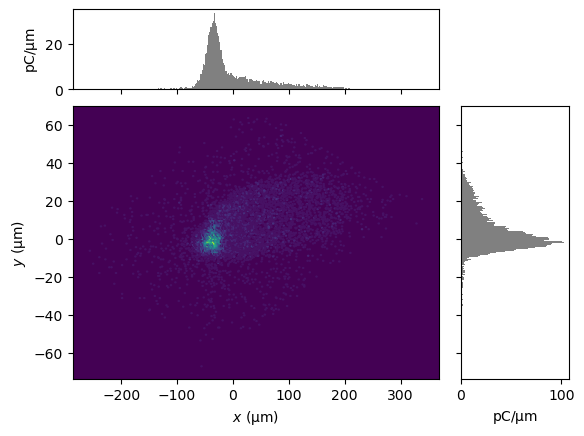

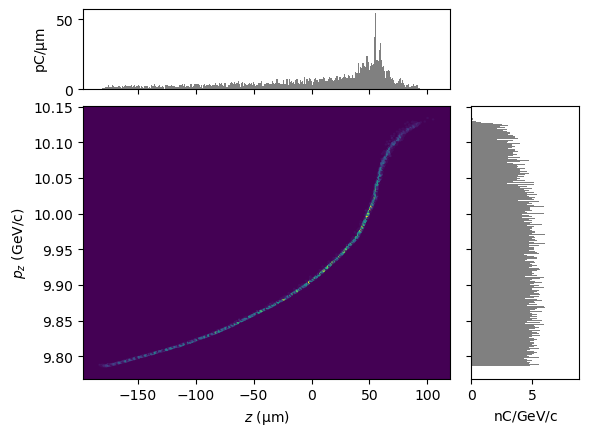

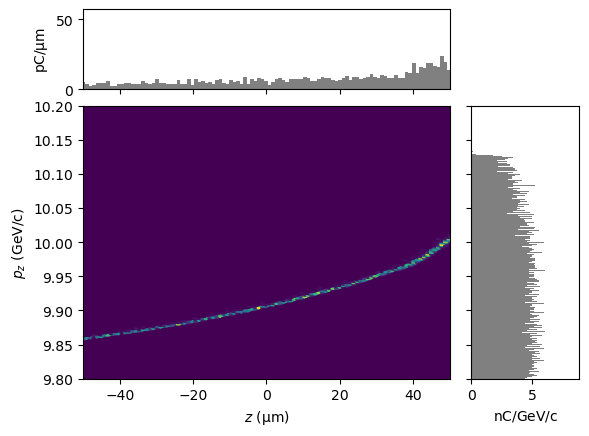

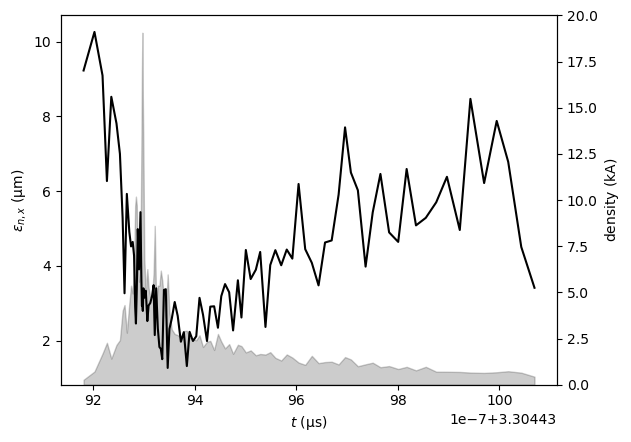

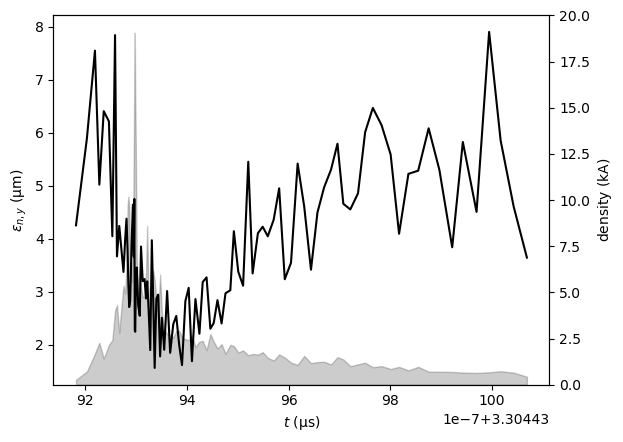

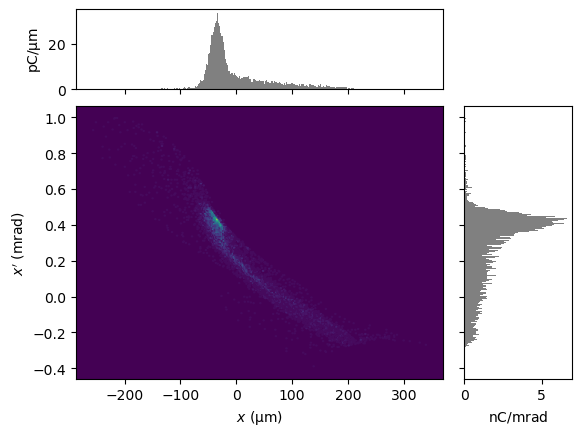

<Figure size 640x480 with 0 Axes>

In [8]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
if bunchCount == 2:
    print("Witness:")
    display(plotMod(PWitness, 'x', 'y',  bins=300))
    
display(plotMod(P, 'z', 'pz', bins=300))


display(plotMod(P, 'z', 'pz', bins=300, xlim = (-50e-6, 50e-6), ylim = (9.8e9, 10.2e9)))


display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
display(slicePlotMod(P, 'norm_emit_y', slice_key = "t", n_slice=100))

display(plotMod(P, 'x', 'xp', bins=300))
plt.clf()

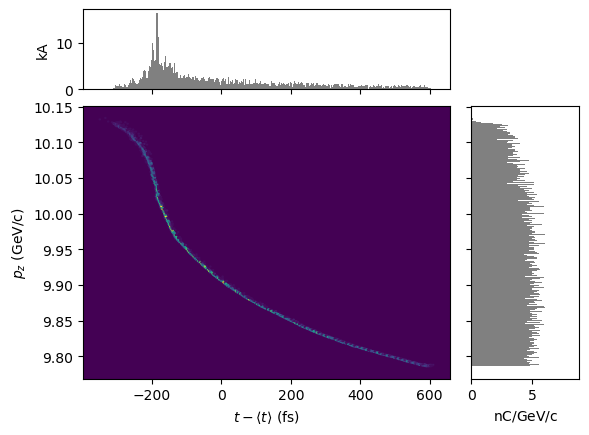

In [9]:
display(plotMod(PDrive, 'delta_t', 'pz', bins=300))

In [10]:
# P = getBeamAtElement(tao, "YCWIGE")
# display(plotMod(PDrive, 'x', 'y',  bins=300))
# display(plotMod(PDrive, 'x', 'z',  bins=300))
# display(plotMod(PDrive, 'x', 'energy',  bins=300))

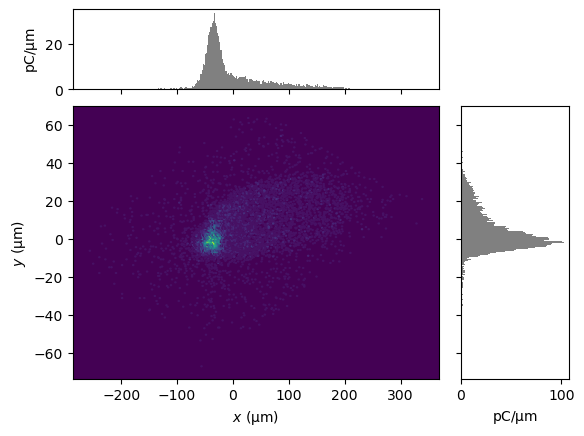

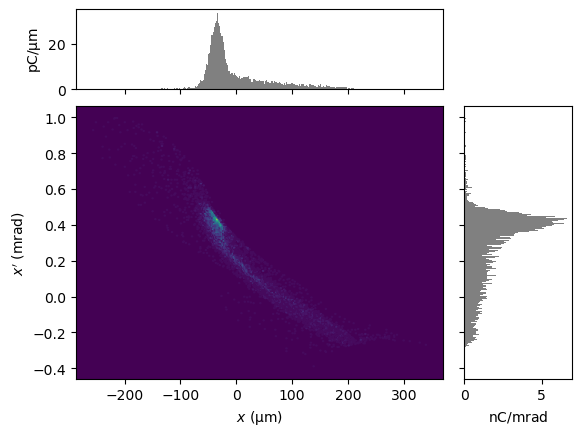

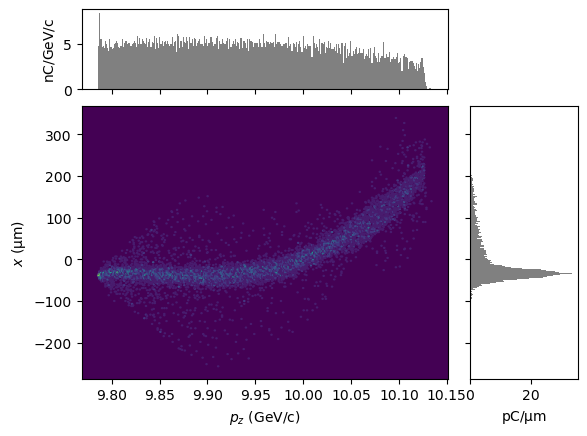

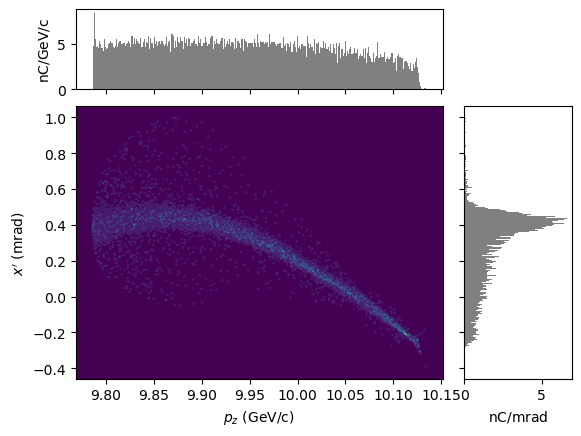

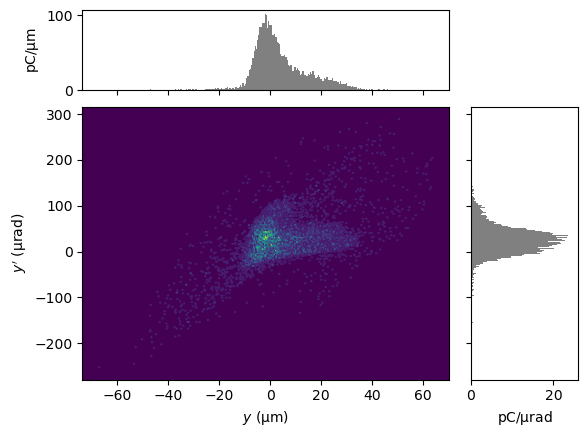

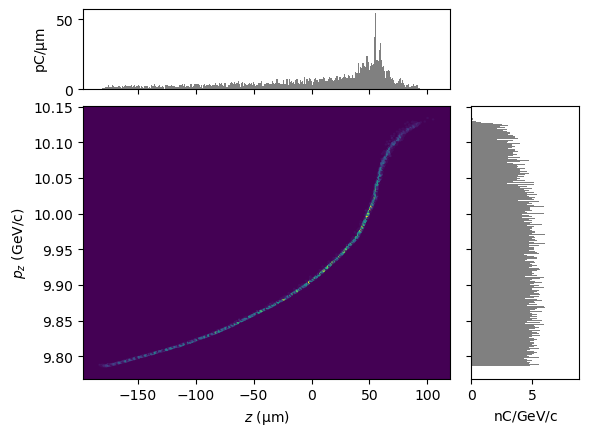

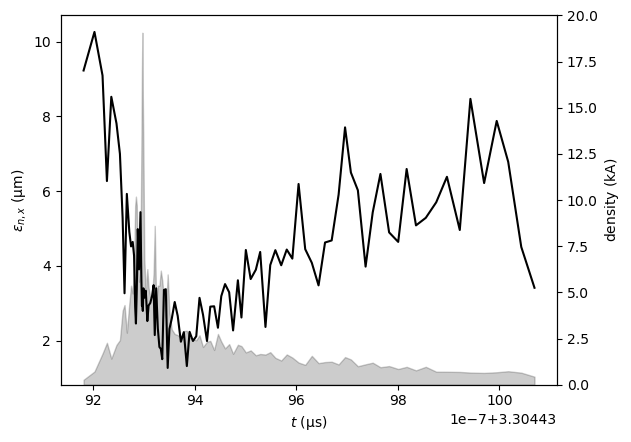

In [11]:
display(plotMod(PDrive, 'x', 'y',  bins=300))

display(plotMod(PDrive, 'x', 'xp', bins=300))
display(plotMod(PDrive, 'pz', 'x', bins=300))
display(plotMod(PDrive, 'pz', 'xp', bins=300))

display(plotMod(PDrive, 'y', 'yp', bins=300))
display(plotMod(PDrive, 'z', 'pz', bins=300))
display(slicePlotMod(PDrive, 'norm_emit_x',n_slice=100))

## Further study at other elements

In [12]:
P = getBeamAtElement(tao, "PR10571")
#PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.0130916663276346, 1.0088154308603305

System emit:  2.291325888444923e-06, 1.6989721227754064e-06


In [13]:
P = getBeamAtElement(tao, "BEGBC20")
#PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")


System BMAG:  1.0224784137331837, 1.317863928940358

System emit:  6.29888534557075e-06, 2.36477613266807e-06


In [14]:
P = getBeamAtElement(tao, "MFFF")
#PDrive, PWitness = getDriverAndWitness(P)
PDrive = P


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 26.432822459542756, 24.32521664932554
Drive alpha x / y: -3.77536914264606, -1.218091822686684

System BMAG:  2.5367528114626037, 1.0557969379699117

System emit:  3.155373356763023e-05, 3.7945513770761633e-06


In [15]:
P = getBeamAtElement(tao, "PENT")
#PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

#print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
#print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 0.97331402110197, 0.41462311709912586
System alpha x / y: 2.3890362000704815, -0.7776003461600356
System BMAG:  2.6961634355317274, 1.3821658276787274

System emit:  2.7388742414611083e-05, 2.9741451533644125e-06


PR10571


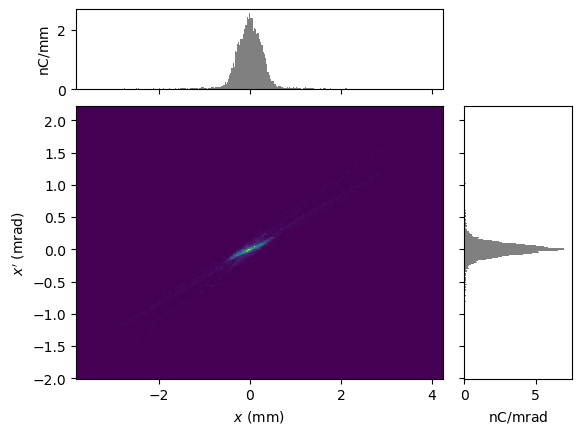

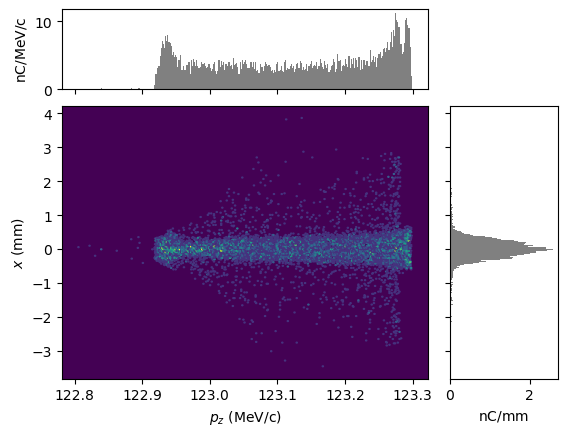

BEGBC20


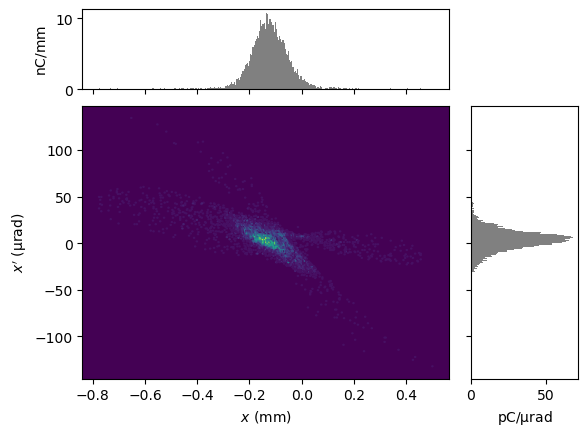

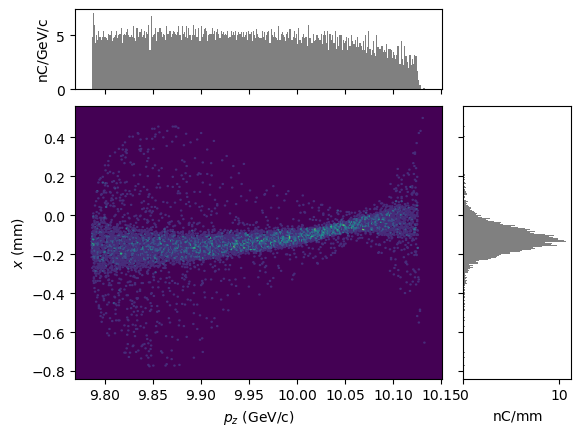

MFFF


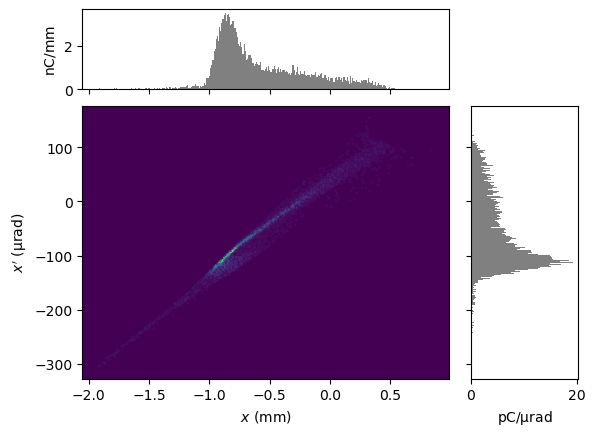

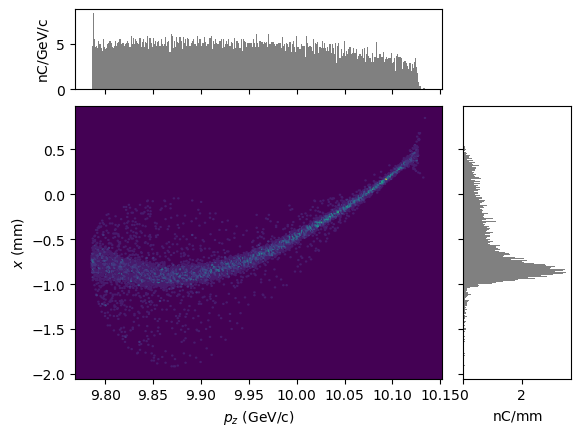

PENT


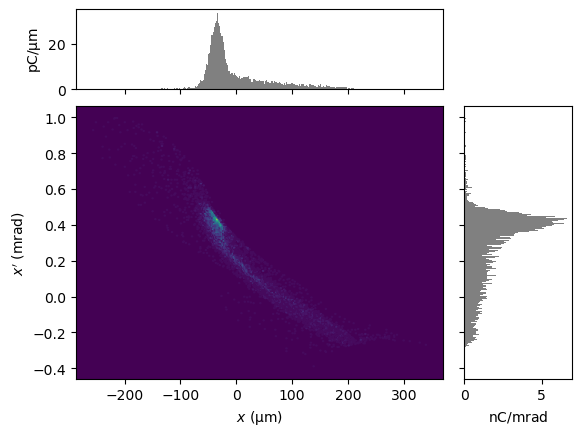

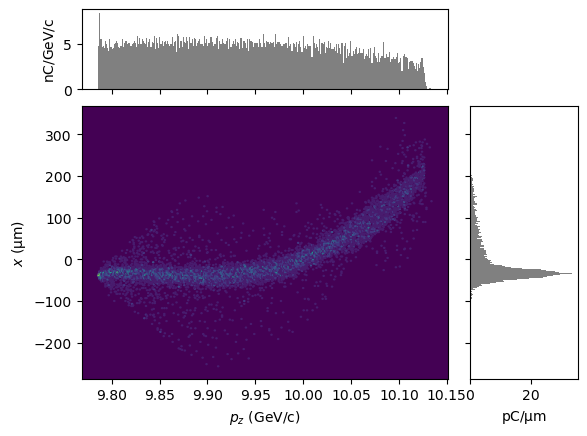

In [16]:
for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    #PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(P, 'x', 'xp',  bins=300))
    display(plotMod(P, 'pz', 'x',  bins=300))

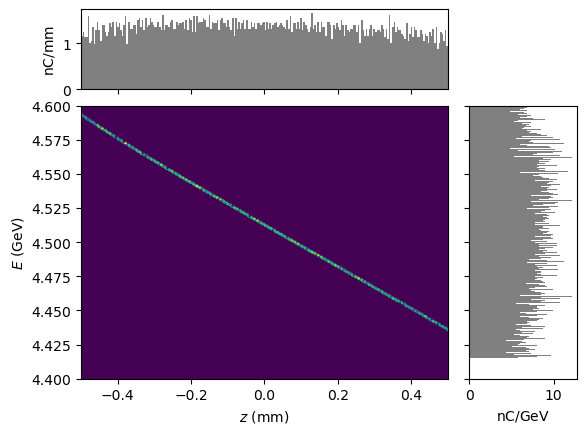

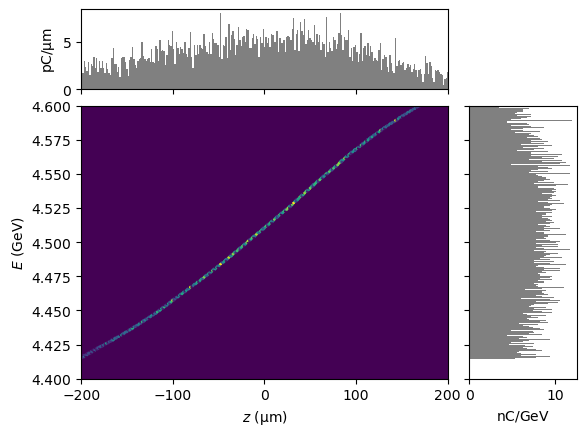

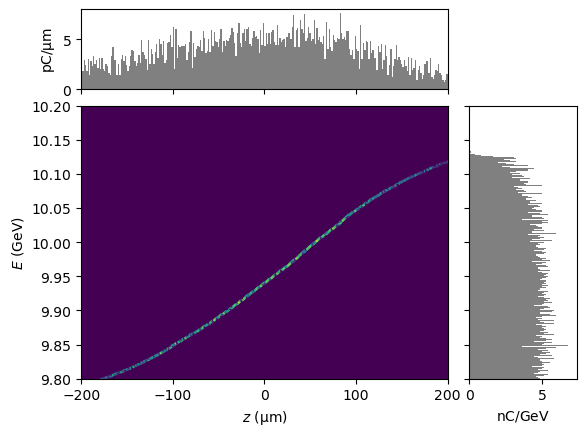

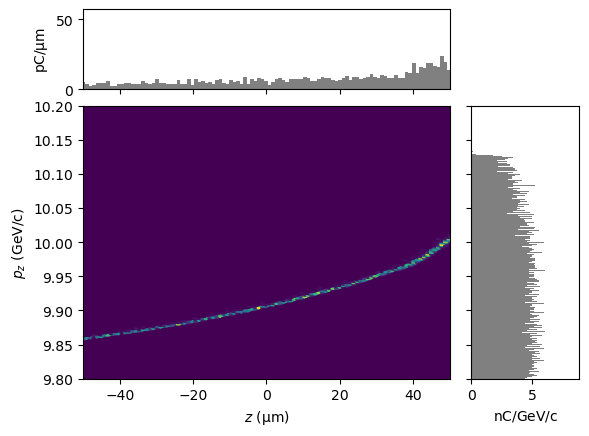

In [17]:
P = getBeamAtElement(tao, "BEGBC14_1")
display(plotMod(P, 'z', 'energy',  bins=300, xlim = (-500e-6, 500e-6), ylim = (4.4e9, 4.6e9)))

P = getBeamAtElement(tao, "ENDBC14_2")
display(plotMod(P, 'z', 'energy',  bins=300, xlim = (-200e-6, 200e-6), ylim = (4.4e9, 4.6e9)))

P = getBeamAtElement(tao, "BEGBC20")
display(plotMod(P, 'z', 'energy',  bins=300, xlim = (-200e-6, 200e-6), ylim = (9.8e9, 10.2e9)))

P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-50e-6, 50e-6), ylim = (9.8e9, 10.2e9)))

# Check beam specs at treaty points

In [18]:
print("DL10")
getMatrix(tao,"LH10END", "BEGL1F",print=True);
print("BC11")
getMatrix(tao,"BEGBC11_1", "BEGL2F",print=True);
print("BC14")
getMatrix(tao,"ENDL2F", "BEGL3F_1",print=True);
print("BC20")
getMatrix(tao,"BEGBC20", "MFFF",print=True);

DL10


4.624840,-0.934883,0.000000,-0.000000,0.000000,0.000000
-1.006413,0.419664,-0.000000,0.000000,0.000000,-0.000000
-0.000000,-0.000000,-0.636892,-1.993803,0.000000,0.000000
-0.000000,0.000000,0.077541,-1.327383,0.000000,-0.000000
-0.000000,0.000000,0.000000,-0.000000,1.000000,-0.006136
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC11


5.503387,-24.775546,0.000000,0.000000,0.000000,-0.000000
-0.203411,1.097438,-0.000000,-0.000000,0.000000,0.000000
-0.000000,0.000000,0.353439,2.781447,0.000000,0.000000
0.000000,-0.000000,-0.601774,-1.906419,0.000000,-0.000000
-0.000000,0.000000,-0.000000,-0.000000,1.000000,0.046019
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC14


0.017654,17.783583,0.000000,0.000000,-0.000000,0.000007
-0.055045,1.195609,0.000000,-0.000000,-0.000000,0.000001
0.000000,-0.000000,-1.113736,35.842066,0.000000,-0.000000
0.000000,-0.000000,-0.004219,-0.762114,-0.000000,-0.000000
-0.000000,-0.000016,0.000000,0.000000,1.000000,0.036014
0.000000,0.000000,0.000000,0.000000,-0.000000,1.000000


BC20


-1.721138,-4.703421,-0.017528,-0.324831,0.000000,0.090967
-0.358329,-1.560015,-0.003405,-0.084274,0.000000,0.012743
-0.014223,-0.107559,0.312318,12.533195,0.000000,-0.006088
0.003733,0.002134,-0.111525,-1.274784,0.000000,-0.000412
-0.010692,-0.082031,0.000721,0.009393,1.000000,-0.011293
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [19]:
P = getBeamAtElement(tao, "L0BFEND")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""SI90 emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")
print(f"""norm_emit: {1e6 * P["norm_emit_x"]}, {1e6 * P["norm_emit_y"]} um-rad""")

E: 0.12312316541449535 GeV 
sig_z: 566.0293865558142 um
sig_E: 0.08654833513980609 %
SI90 emittance: 1.8473820641837284, 2.6887926709168686 um-rad
norm_emit: 6.299171304207024, 5.085323939715542 um-rad


In [20]:
P = getBeamAtElement(tao, "BEGL2F")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 0.3316449513759229 GeV 
sig_z: 331.1104411676252 um
sig_E: 0.48848834629348425 %


In [21]:
P = getBeamAtElement(tao, "BEGL3F_1")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 4.512061313076305 GeV 
sig_z: 102.3335053112089 um
sig_E: 1.1544827615530655 %


In [22]:
P = getBeamAtElement(tao, "BEGBC20")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")

E: 9.945618524082821 GeV 
sig_z: 102.35547239091055 um
sig_E: 0.8910588493875353 %
emittance: 11.706328457079666, 4.794677220981031 um-rad


In [23]:
P = getBeamAtElement(tao, "PENT")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 9.94427698853808 GeV 
sig_z: 60.98879976557225 um
sig_E: 0.892455499099131 %


L0AFEND


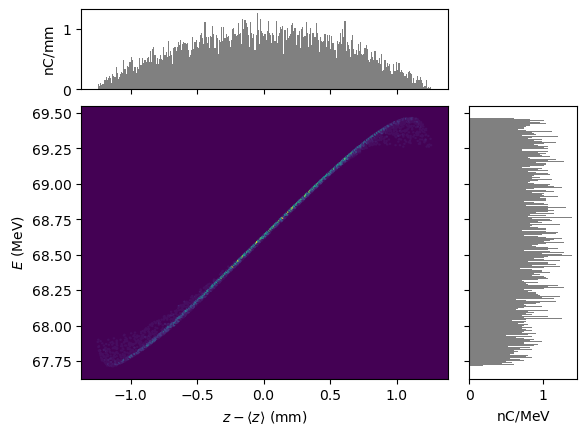

BEGL2F


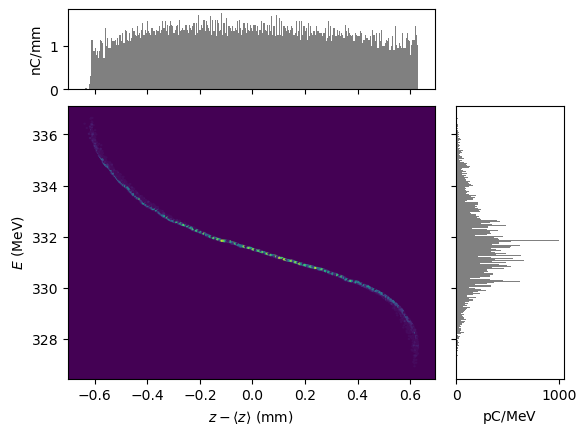

BEGBC14_1


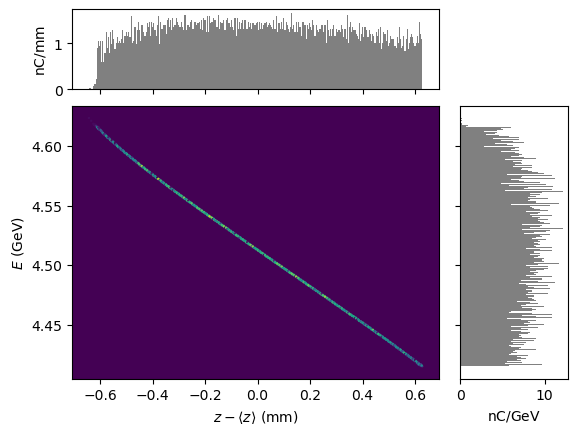

ENDBC14_2


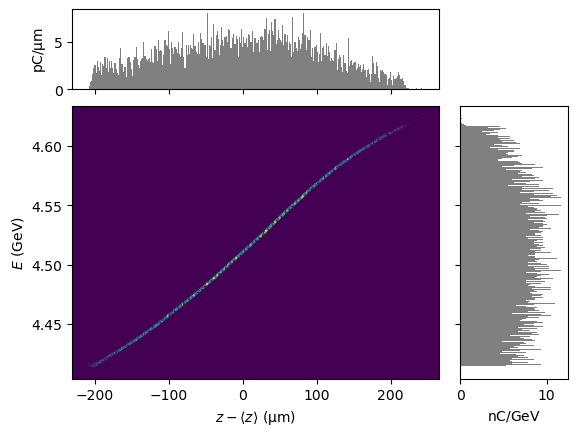

BEGBC20


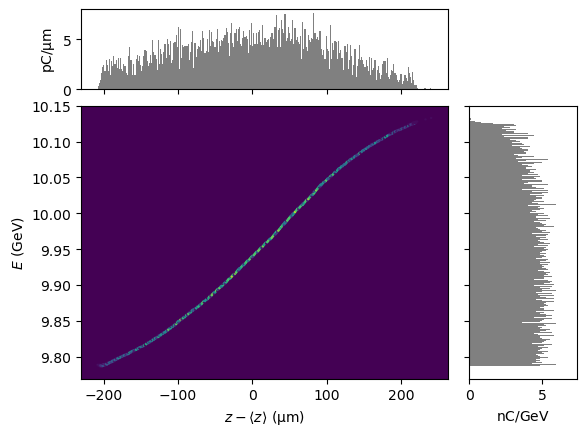

PENT


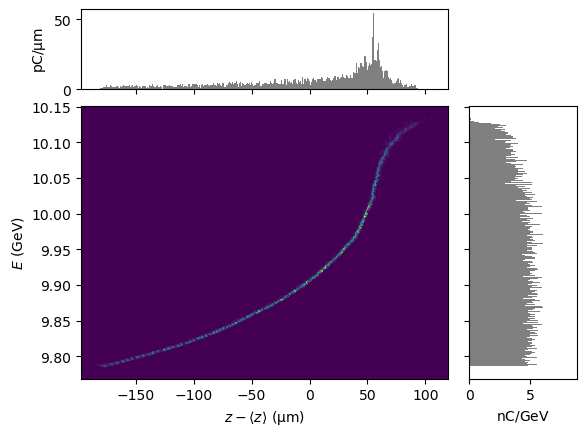

In [24]:
for activeElement in ["L0AFEND", "BEGL2F", "BEGBC14_1", "ENDBC14_2", "BEGBC20", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    display(plotMod(P, 'delta_z', 'energy',  bins=300))